## 6. Classification
### 1. Merge one hot encoded genres to lyrics

In [ ]:
import pandas as pd

lyrics = pd.read_csv('../dataset/Lyrics_en_clean.csv', index_col=['Band','Song'])
genres = pd.read_csv('../dataset/artists_final_ohe.csv', index_col=['Band'])

In [ ]:
#df = pd.concat([lyrics, genres], axis=1, join_axes=[lyrics.index], levels=lyrics.index.levels)
df = pd.merge(lyrics, genres, on=['Band'])
del lyrics
del genres
df

### 2. Labels exploration  

In [3]:
%matplotlib inline
data = df.drop(['Lyrics'], axis = 1)
#pd.scatter_matrix(df, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

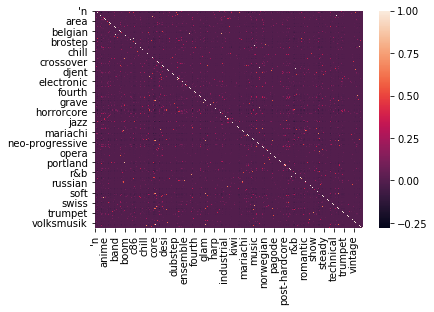

In [4]:
import seaborn as sns
sns.heatmap(data.corr())

In [ ]:
from sklearn.decomposition import PCA
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np


good_data = data
pca = PCA()
pca.fit(good_data)

# Dimension indexing
dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

# PCA components
components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
components.index = dimensions

# PCA explained variance
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
variance_ratios.index = dimensions

# Create a bar plot visualization
fig, ax = plt.subplots(figsize = (14,8))

# Plot the feature weights as a function of the components
components.plot(ax = ax, kind = 'bar');
ax.set_ylabel("Feature Weights")
ax.set_xticklabels(dimensions, rotation=0)


# Display the explained variance ratios
for i, ev in enumerate(pca.explained_variance_ratio_):
    ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

# Return a concatenated DataFrame
pd.concat([variance_ratios, components], axis = 1)

In [ ]:
from sklearn.cluster import FeatureAgglomeration

clf = FeatureAgglomeration(n_components=200)
reduced_data = clf.fit_transform(data)  

### 3. Split  

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.4)
test, valid = train_test_split(test, test_size=0.4)

print('Total shape: ',df.shape)
print('Train shape: ',train.shape)
print('Test shape: ',test.shape)
print('Valid shape: ',valid.shape)

del df

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

X_train = train['Lyrics']
y_train = train.drop('Lyrics', axis=1)

X_train_counts = CountVectorizer().fit_transform(X_train)
X_train_tfidf = TfidfTransformer().fit_transform(X_train_counts)

del X_train
del X_train_counts

In [ ]:
X_test = test['Lyrics']
y_test = test.drop('Lyrics', axis=1)

X_test_counts = CountVectorizer().fit_transform(X_test)
X_test_tfidf = TfidfTransformer().fit_transform(X_test_counts)

del X_test
del X_test_counts

In [10]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train_tfidf, y_train)

MemoryError: could not allocate 5419040768 bytes

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

X_test = test['Lyrics']
X_test_counts = CountVectorizer().fit_transform(X_test)
X_test_tfidf = TfidfTransformer().fit_transform(X_test_counts)

del X_test
del X_test_counts

y_test = test.drop('Lyrics', axis=1)
y_pred = clf.predict(X_test_tfidf)
accuracy_score(y_test, y_pred)

KeyboardInterrupt: 

In [ ]:
import numpy as np
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from keras.utils import Sequence

class My_Generator(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(self.x.shape[0] / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return batch_x.toarray(), np.array(batch_y)

KERAS

In [ ]:

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
## Plotly
#import plotly.offline as py
#import plotly.graph_objs as go
#py.init_notebook_mode(connected=True)

#from sklearn.manifold import TSNE

batch_size = 16
my_training_batch_generator = My_Generator(X_train_tfidf, y_train, batch_size)
num_training_samples = X_train_tfidf.shape[0]
num_epochs = 3
my_validation_batch_generator = My_Generator(X_test_tfidf, y_test, batch_size)
num_validation_samples = X_test_tfidf.shape[0]

model_conv = Sequential()
model_conv.add(Embedding(input_dim=num_training_samples, output_dim=100))
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(LSTM(100))
model_conv.add(Dense(y_train.shape[1], activation='sigmoid'))
model_conv.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['accuracy'])
model_conv.summary()

#model_conv.fit(X_train_tfidf, y_train, validation_split=0.2, epochs = 3, batch_size=16)
model_conv.fit_generator(generator=my_training_batch_generator,
                      steps_per_epoch=(num_training_samples // batch_size),
                      epochs=num_epochs,
                      verbose=1,
                      validation_data=my_validation_batch_generator,
                      validation_steps=(num_validation_samples // batch_size),
                      #use_multiprocessing=True,
                      workers=8,
                      max_queue_size=32)

In [24]:
model = Sequential()
model.add(Dense(32, input_dim=163723))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(646))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

model.fit(X_train_tfidf, y_train, epochs=5, batch_size=16, validation_split=0.1)


C:\Users\juanp\Anaconda3\envs\mlnd\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Train on 210209 samples, validate on 23357 samples
Epoch 1/5


ResourceExhaustedError: OOM when allocating tensor with shape[8] and type bool on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: loss_15/activation_26_loss/NotEqual = NotEqual[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_activation_26_sample_weights_0_2/_1185, training_12/RMSprop/Const)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: loss_15/mul/_1215 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_536_loss_15/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [6]:
print('algo')

algo
